# Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import json 
import pandas as pd 
import numpy as np 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

# Location of likelihood maxima

In [147]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import LinearModel
from kalman_filter import KalmanFilter
from priors import priors_dict,bilby_priors_dict
import numpy as np 



#Function to create synthetic data
def create_synthetic_data(h,measurement_noise,seed):

    P    = SystemParameters(h=h,σp=None,σm=measurement_noise,seed=seed)       #define the system parameters as a class
    PTA  = Pulsars(P)               # setup the PTA
    data = SyntheticData(PTA,P)     # generate some synthetic data

    return P,PTA,data

#Fit model to data and return likelihood
def get_likelihood(data,iota_value,h_value,P,PTA,measurement_model):

    _P = copy.copy(P)
    _PTA = copy.copy(PTA)
    _P.measurement_model = measurement_model
    

    #Define the model 
    model = LinearModel(_P)

    #Initialise the Kalman filter
    KF = KalmanFilter(model,data.f_measured,_PTA)

    #Get the
    guessed_parameters = priors_dict(_PTA,_P) #These are the true parameters 
    
    guessed_parameters['iota_gw'] = np.array([iota_value])
    guessed_parameters['h'] = np.array([h_value])
    
   # model_likelihood = KF.likelihood(guessed_parameters)
    model_likelihood, model_state_predictions_x1,model_state_predictions_y1 = KF.likelihood_with_results(guessed_parameters)


    return model_likelihood




import matplotlib.pyplot as plt 
import scienceplots
def likelihood_plot(x,y,z,h_true,iota_true,lower_limit):


    plt.style.use('science')
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)


    #Load the data
    #data = np.load(path)
    iota_values = x
    h_values = y
    surface_pulsar = z
    max_l_val = np.max(z)
    surface_pulsar = surface_pulsar / np.abs(np.max(surface_pulsar)) #Normalize

    #Extract location of maxima
    iota_idx, h_idx = np.unravel_index(surface_pulsar.argmax(), surface_pulsar.shape)
    xc = iota_values[iota_idx]
    yc = h_values[h_idx]
    zc = surface_pulsar[iota_idx,h_idx]

    #Cast to 2D mesh
    X,Y = np.meshgrid(h_values,iota_values)
    lx = len(iota_values)
    ly = len(h_values)
    z = np.reshape(surface_pulsar, (lx, ly))



    #Plot colormap
    CS = ax.pcolormesh(X, Y, z,clim=(lower_limit, np.max(surface_pulsar)),shading='gouraud',cmap='viridis')
    #CS = ax.pcolormesh(X, Y, z,clim=(np.min(surface_pulsar), np.max(surface_pulsar)),shading='gouraud',cmap='viridis')

    clb = plt.colorbar(CS)



    #Config
    ax.set_xscale('log')
    ax.scatter(yc,xc, s=20,c='C3')
    print("Likelihood maxima occurs at: ", yc,xc, "with a value = ", np.max(max_l_val))

    print("In comparison the injected vals are", iota_true,h_true)
    get_likelihood(data,iota_true,h_true,P,PTA,measurement_model)


    ax.scatter(h_true,iota_true, s=20,c='C4',marker='*')
    fs = 20
    ax.set_xlabel(r'$h_0$', fontsize=fs)
    ax.set_ylabel(r'$\iota$', fontsize=fs)
    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)
    clb.ax.tick_params(labelsize=fs-4) 
    clb.ax.set_title(r'$\log \mathcal{L}$',fontsize=fs-4)
    savefig = 'likelihood_surface'
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    plt.setp(ax.get_yticklabels()[0], visible=False)   #no 0th label to prevent overlap  





# Small noise 

In [36]:

h = 1e-12
measurement_noise = 1e-15
seed=1303
P,PTA,data = create_synthetic_data(h,measurement_noise,seed)


import copy 
import logging 
logger = logging.getLogger().setLevel(logging.ERROR)


#set the measurement model
measurement_model = 'pulsar' #Set the measurement model 
N = 100

h_range = np.arange(0.5e-12,1.5e-12,1e-14)
iota_range = np.arange(0.8,1.2,0.01)

likelihood_curves = np.zeros((len(iota_range),len(h_range)))             

for i,iota in enumerate(iota_range):
    for j,hval in enumerate(h_range):
        likelihood_curves[i,j] = get_likelihood(data,iota,hval,P,PTA,measurement_model)

chi vals are =  [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]


Likelihood maxima occurs at:  9.999999999999978e-13 1.0000000000000002 with a value =  1.0
In comparison the injected vals are


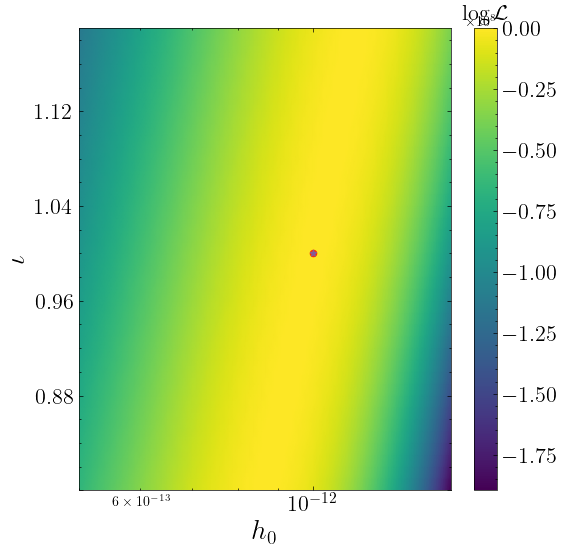

In [37]:
likelihood_plot(iota_range,h_range,likelihood_curves)

# Canonical noise

In [155]:

h = 5e-15
measurement_noise = 1e-11
seed=1260



#notable seeds
#1299,1251


P,PTA,data = create_synthetic_data(h,measurement_noise,seed)

print("iota = ", P.ι)
import copy 
import logging 
logger = logging.getLogger().setLevel(logging.ERROR)


#set the measurement model
measurement_model = 'pulsar' #Set the measurement model 
N = 10

h_range = np.arange(4e-15,6e-15,1e-16)
iota_range = np.arange(0.8,1.2,0.01)

# h_range = np.logspace(-16,-14,N)
# iota_range = np.linspace(0.0,np.pi,N)

likelihood_curves = np.zeros((len(iota_range),len(h_range)))             

for i,iota in enumerate(iota_range):
    for j,hval in enumerate(h_range):
        likelihood_curves[i,j] = get_likelihood(data,iota,hval,P,PTA,measurement_model)

chi vals are =  [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]
iota =  1.0


Likelihood maxima occurs at:  4e-15 0.8 with a value =  nan
In comparison the injected vals are 1.0 5e-15


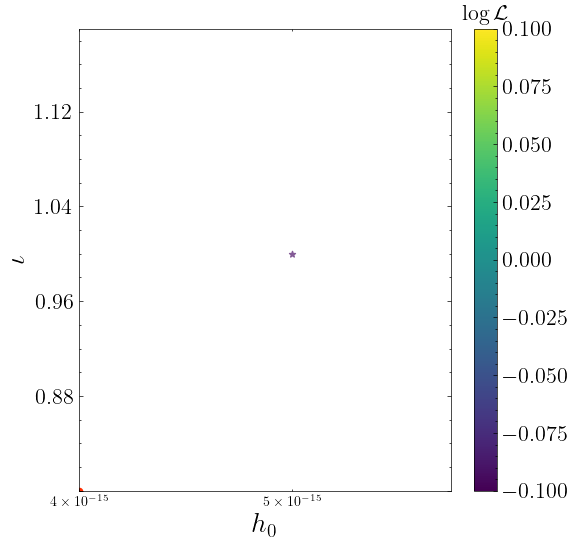

In [156]:
eps = 1e-13
likelihood_plot(iota_range,h_range,likelihood_curves,h,1.0,lower_limit=0.999999)

In [118]:
likelihood_curves[0][0] - likelihood_curves[0][-1]

0.0

# Raw results

In [73]:
def plot_all_side_hist(t,states,measurements,measurements_clean,predictions_x,predictions_y,psr_index,savefig=None):

    plt.style.use('science')

    tplot = t / (365*24*3600)
    state_i = states[:,psr_index]
    measurement_i = measurements[:,psr_index]
    measurement_clean_i = measurements_clean[:,psr_index]



    h,w = 15,8

 
    fig = plt.figure(figsize=(h,w))

    rows = 3
    cols = 2
    ax1 = plt.subplot2grid((3, 2), (0, 0))
    ax2 = plt.subplot2grid((3, 2), (1, 0))
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (0, 1),rowspan=3)



    nHz = 1e9
    ax1.plot(tplot,state_i*nHz,label='state',c='C0')

    try:

        prediction_i = predictions_x[:,psr_index]
        ax1.plot(tplot,prediction_i*nHz,label = 'prediction',c='C1')
    except:
        pass
    
    ax2.plot(tplot,measurement_i*nHz,label="measurement",c="C3")
    #ax2.plot(tplot,measurement_clean_i,label="measurement_clean",c="C5")


    try:
        prediction_i_y = predictions_y[:,psr_index]
        ax2.plot(tplot,prediction_i_y*nHz,label="prediction",c="C4")

        #Residuals
        residuals = (prediction_i_y-measurement_i) * nHz #nHz


        #print("Calculating residual")
        #print(prediction_i_y)
        #print(measurement_i)


        ax3.plot(tplot,residuals,c='C2')

        print("Mean abs residual:", np.mean(np.abs(residuals)))
        ax4.hist(residuals,bins=50)

    except:
        pass 

    #ax1.legend()
    #ax2.legend()


    fs=18
    ax3.set_xlabel('t [years]', fontsize=fs)
    ax1.set_ylabel(r"$f'_{\rm p}$ [nHz]", fontsize=fs)
    ax2.set_ylabel(r'$f_{\rm m}$ [nHz]', fontsize=fs)
    ax3.set_ylabel(r'$\epsilon$ [nHz]', fontsize=fs)

    ax3.xaxis.set_tick_params(labelsize=fs-4)
    
    ax3.yaxis.set_tick_params(labelsize=fs-4)
    ax2.yaxis.set_tick_params(labelsize=fs-4)
    ax1.yaxis.set_tick_params(labelsize=fs-4)

    plt.subplots_adjust(wspace=0.12, hspace=0.0)


    ax2.yaxis.set_major_locator(plt.MaxNLocator(3))



    ax4.yaxis.set_tick_params(labelsize=fs-4)
    ax4.xaxis.set_tick_params(labelsize=fs-4)
    ax4.set_xlabel(r'$\epsilon$ [nHz]', fontsize=fs)
    ax4.set_ylabel(r'Count', fontsize=fs,labelpad=-2)


    ax1.legend()

    #plt.rcParams["font.family"] = "fantasy"


    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)
   

    plt.show()

chi vals are =  [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]
Model likelihood is:  586493.9243939972
Mean abs residual: 0.008391465122345215


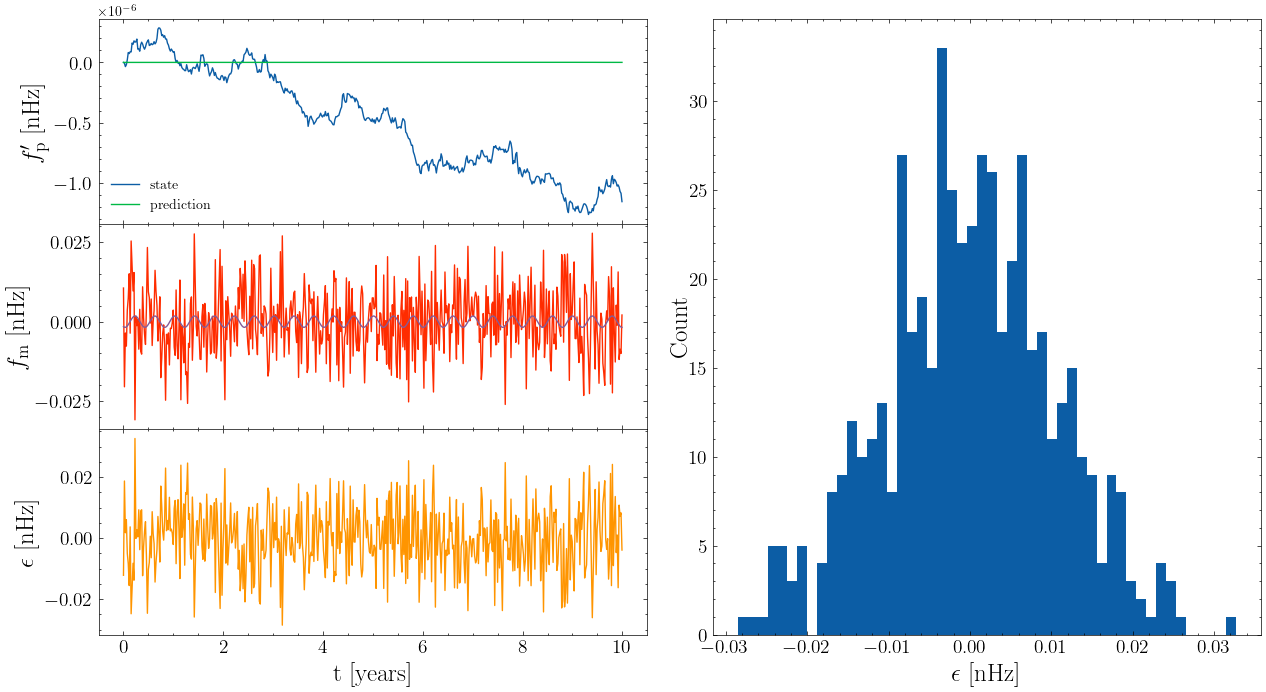

chi vals are =  [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]
Model likelihood is:  586493.9278598141
Mean abs residual: 0.008391495090240092


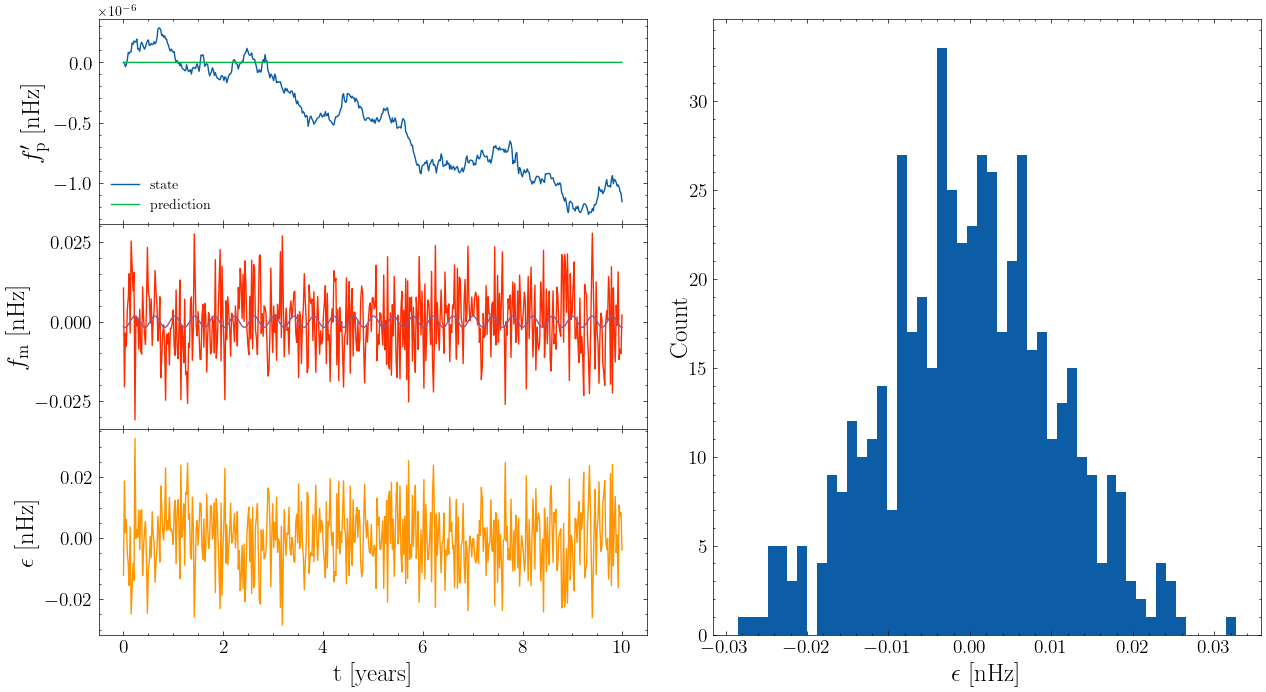

In [154]:
import numpy as np 

seed = 1260
h=5e-15
measurement_noise = 1e-11 


# # Correct parameters example 
# #P    = SystemParameters(h=1e-12,σp=None,σm=1e-15)       #define the system parameters as a class
# P    = SystemParameters(h=h,σp=None,σm=1e-11,seed = seed)
# PTA  = Pulsars(P)               # setup the PTA
# data = SyntheticData(PTA,P) # generate some synthetic data



P,PTA,data = create_synthetic_data(h,measurement_noise,seed)

#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood_with_results(true_parameters)
print("Model likelihood is: ", model_likelihood)

plot_all_side_hist(PTA.t, data.intrinsic_frequency, data.f_measured,data.f_measured_clean, model_state_predictions_x,model_state_predictions_y, psr_index=1,savefig='Kalman_example_true_params')




# #Incorrect parameters example 

import numpy as np 

# P    = SystemParameters(h=h,σp=None,σm=1e-11,seed = seed)
# PTA  = Pulsars(P)               # setup the PTA
# data = SyntheticData(PTA,P) # generate some synthetic data


P,PTA,data = create_synthetic_data(h,measurement_noise,seed)




#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)

wrong_parameters = true_parameters.copy()
wrong_parameters["h"] = np.array([4.5000000000000005e-15]) #Change one of the parameters which is fed to the KF
wrong_parameters["iota_gw"] = np.array([0.8600000000000001]) #Change one of the parameters which is fed to the KF


model_likelihood, model_state_predictions_x1,model_state_predictions_y1 = KF.likelihood_with_results(wrong_parameters)
print("Model likelihood is: ", model_likelihood)
plot_all_side_hist(PTA.t, data.intrinsic_frequency, data.f_measured,data.f_measured_clean, model_state_predictions_x1,model_state_predictions_y1, psr_index=1,savefig='Kalman_example_true_params')


In [ ]:
586493.9277808826